In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split,StratifiedKFold,KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier,plot_tree
import metrics


In [3]:
animal_data = pd.read_csv("animal_data_clean.csv")
animal_data.head()

,Group,A_C1W1T0,A_C2W1T0,L_C1W1T0,L_C2W1T0,A_C1W2T0,A_C2W2T0,L_C1W2T0,L_C2W2T0,A_C1W3T0,...,rC_C2W3T2,lC_C2W4T2,cC_C2W4T2,rC_C2W4T2,lC_C2W5T2,cC_C2W5T2,rC_C2W5T2,Level_70_70,Level_70_90,Level_90_90
0,0,0.000002,0.000003,1.352459,11.270492,0.000005,0.000006,2.090164,12.008197,0.000004,...,0.000258,0.000033,0.000092,0.000078,0.000058,0.000031,0.000016,True,False,False
1,0,0.000002,0.000005,1.311475,11.188525,0.000005,0.000008,2.008197,11.885246,0.000004,...,0.000228,0.000090,0.000122,0.000080,0.000059,0.000041,0.000010,False,True,False
2,0,0.000004,0.000004,1.311475,11.229508,0.000008,0.000008,2.049180,12.008197,0.000006,...,0.000209,0.000104,0.000096,0.000037,0.000078,0.000073,0.000030,False,False,True
3,0,0.000006,0.000006,1.352459,11.270492,0.000005,0.000006,2.131148,12.049180,0.000004,...,0.000091,0.000044,0.000081,0.000074,0.000026,0.000055,0.000030,True,False,False
4,0,0.000005,0.000010,1.311475,11.188525,0.000006,0.000008,2.049180,11.926230,0.000004,...,0.000140,0.000084,0.000098,0.000063,0.000033,0.000022,0.000017,False,True,False


In [4]:
Y = animal_data['Group']
X = animal_data.drop(['Group'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42,stratify=Y)

In [8]:
zscore_scaler = MinMaxScaler()
numeric_columns = X_train.select_dtypes(include=['float64', 'int64']).columns
X_train_normalized = X_train.copy()  
X_train_normalized[numeric_columns] = zscore_scaler.fit_transform(X_train[numeric_columns])

# Transform the testing data using the same scaler to avoid data leakage
X_test_normalized = X_test.copy()  
X_test_normalized[numeric_columns] = zscore_scaler.transform(X_test[numeric_columns])

## Hyperparameter Tuning

In [9]:
## hyperparameters:
learning_rate = [0.01,0.1,1,1.5,2,10]
n_estimators = [50,100,150,200]
grid_result_list = []
skf = StratifiedKFold(n_splits=5)

In [10]:
for rate in learning_rate:
    for n_estimator in n_estimators:
        grid_result = {}
        grid_result['n_estimators'] = n_estimator
        grid_result['learning_rate'] = rate
        
        for i,(train_index,test_index) in enumerate(skf.split(X_train_normalized,y_train)):
            train_features, train_label = X_train_normalized.iloc[train_index], y_train.iloc[train_index]
            test_features, test_label = X_train_normalized.iloc[test_index], y_train.iloc[test_index]

            ## define model 
            Ada_classifier = AdaBoostClassifier(n_estimators=n_estimator, random_state=0,learning_rate=rate)  ## setting the random_state for reproducability
            Ada_classifier.fit(train_features,train_label)

            ypred = Ada_classifier.predict(test_features)
            dt_metrics = metrics.metrics(test_label,ypred)
            precisions,recalls,f1_scores,macro_f1,weighted_f1 = dt_metrics.f1_score()
            acc = dt_metrics.compute_accuracy()

            grid_result[f'accuracy_fold{i}'] = acc
            grid_result[f'f1_scores_fold{i}'] = f1_scores
            grid_result[f'macro_f1_fold{i}'] = macro_f1
            grid_result[f'weighted_f1_fold{i}'] = weighted_f1
            
        ##compute the average values
        grid_result['avg_acc'] = 0.2*sum([grid_result[f'accuracy_fold{i}'] for i in np.arange(5)])
        grid_result['avg_weighted_f1'] = 0.2*sum([grid_result[f'weighted_f1_fold{i}'] for i in np.arange(5)])
        grid_result['avg_macro_f1'] = 0.2*sum([grid_result[f'macro_f1_fold{i}'] for i in np.arange(5)])
        grid_result_list.append(grid_result)


            

In [11]:
grid_df = pd.DataFrame(grid_result_list)

In [12]:
grid_df

,n_estimators,learning_rate,accuracy_fold0,f1_scores_fold0,macro_f1_fold0,weighted_f1_fold0,accuracy_fold1,f1_scores_fold1,macro_f1_fold1,weighted_f1_fold1,...,f1_scores_fold3,macro_f1_fold3,weighted_f1_fold3,accuracy_fold4,f1_scores_fold4,macro_f1_fold4,weighted_f1_fold4,avg_acc,avg_weighted_f1,avg_macro_f1
0,50,0.01,0.733333,"[0.7500000000000001, 0, 0.8]",0.516667,0.566667,0.827586,"[0.8571428571428571, 0, 0.8571428571428571]",0.571429,0.709360,...,"[0.7741935483870968, 0, 0.8333333333333334]",0.535842,0.607712,0.689655,"[0.742857142857143, 0, 0.7000000000000001]",0.480952,0.501970,0.760460,0.609957,0.533116
1,100,0.01,0.733333,"[0.7647058823529413, 0, 0.7826086956521738]",0.515772,0.566155,0.724138,"[0.7894736842105263, 0.6666666666666666, 0.588...",0.681459,0.532757,...,"[0.7741935483870968, 0, 0.8333333333333334]",0.535842,0.607712,0.620690,"[0.7027027027027025, 0, 0.5555555555555556]",0.419419,0.410790,0.725977,0.556298,0.542636
2,150,0.01,0.700000,"[0.7428571428571429, 0, 0.7272727272727272]",0.490043,0.515844,0.655172,"[0.7499999999999999, 0.6666666666666666, 0.4]",0.605556,0.452299,...,"[0.7741935483870968, 0, 0.8333333333333334]",0.535842,0.607712,0.620690,"[0.717948717948718, 0.5, 0.4]",0.539316,0.405217,0.705517,0.529029,0.546289
3,200,0.01,0.633333,"[0.7179487179487181, 0, 0.5555555555555556]",0.424501,0.427635,0.689655,"[0.7692307692307693, 0.6666666666666666, 0.5]",0.645299,0.489832,...,"[0.7647058823529412, 0, 0.761904761904762]",0.508870,0.552980,0.586207,"[0.7000000000000001, 0.8, 0.15384615384615385]",0.551282,0.398408,0.685287,0.506486,0.538035
4,50,0.10,0.533333,"[0.6666666666666667, 0, 0.26666666666666666]",0.311111,0.328889,0.827586,"[0.8484848484848485, 0, 0.8695652173913043]",0.572683,0.709463,...,"[0.6666666666666666, 0, 0.375]",0.347222,0.337644,0.655172,"[0.7567567567567568, 0.8, 0.375]",0.643919,0.459296,0.658391,0.477654,0.476761
5,100,0.10,0.566667,"[0.6829268292682926, 0.5, 0.26666666666666666]",0.483198,0.353144,0.827586,"[0.8484848484848485, 0, 0.8695652173913043]",0.572683,0.709463,...,"[0.7368421052631579, 0.5, 0.5]",0.578947,0.441924,0.655172,"[0.7368421052631579, 0.8, 0.4]",0.645614,0.452269,0.699540,0.524175,0.568226
6,150,0.10,0.566667,"[0.6829268292682926, 0.5, 0.26666666666666666]",0.483198,0.353144,0.827586,"[0.8484848484848485, 0, 0.8695652173913043]",0.572683,0.709463,...,"[0.8235294117647058, 0.5, 0.8]",0.707843,0.635497,0.689655,"[0.7567567567567568, 0.8, 0.5]",0.685586,0.489469,0.734023,0.570329,0.602000
7,200,0.10,0.566667,"[0.6829268292682926, 0.5, 0.26666666666666666]",0.483198,0.353144,0.862069,"[0.8749999999999999, 0.6666666666666666, 0.869...",0.803744,0.745252,...,"[0.8750000000000001, 0.5, 0.9090909090909091]",0.761364,0.753135,0.689655,"[0.7567567567567568, 0.8, 0.5]",0.685586,0.489469,0.754713,0.601015,0.658916
8,50,1.00,0.766667,"[0.7586206896551724, 0.8, 0.7692307692307692]",0.775950,0.587905,0.862069,"[0.8749999999999999, 0, 0.9166666666666666]",0.597222,0.770115,...,"[0.7333333333333334, 0.4, 0.7826086956521738]",0.638647,0.534833,0.793103,"[0.7999999999999999, 0.5, 0.8333333333333334]",0.711111,0.635632,0.753333,0.584043,0.658722
9,100,1.00,0.700000,"[0.7096774193548386, 0.5, 0.7199999999999999]",0.643226,0.492882,0.896552,"[0.9032258064516129, 0.6666666666666666, 0.916...",0.828853,0.806730,...,"[0.689655172413793, 0.4, 0.75]",0.613218,0.484364,0.793103,"[0.7999999999999999, 0.5, 0.8333333333333334]",0.711111,0.635632,0.746897,0.570615,0.679674


In [13]:
grid_df[['learning_rate','n_estimators','avg_acc','avg_weighted_f1']]

,learning_rate,n_estimators,avg_acc,avg_weighted_f1
0,0.01,50,0.760460,0.609957
1,0.01,100,0.725977,0.556298
2,0.01,150,0.705517,0.529029
3,0.01,200,0.685287,0.506486
4,0.10,50,0.658391,0.477654
5,0.10,100,0.699540,0.524175
6,0.10,150,0.734023,0.570329
7,0.10,200,0.754713,0.601015
8,1.00,50,0.753333,0.584043
9,1.00,100,0.746897,0.570615


In [14]:
learning_rate = ['0.01','0.1','1','1.5','2','10']
n50_ = grid_df[grid_df['n_estimators']==50]
n50_acc = np.array(n50_['avg_acc'])
n50_f1 = np.array(n50_['avg_weighted_f1'])
n100_ = grid_df[grid_df['n_estimators']==100]
n100_acc = np.array(n100_['avg_acc'])
n100_f1 = np.array(n100_['avg_weighted_f1'])
n150_ = grid_df[grid_df['n_estimators']==150]
n150_acc = np.array(n150_['avg_acc'])
n150_f1 = np.array(n150_['avg_weighted_f1'])
n200_ = grid_df[grid_df['n_estimators']==200]
n200_acc = np.array(n200_['avg_acc'])
n200_f1 = np.array(n200_['avg_weighted_f1'])

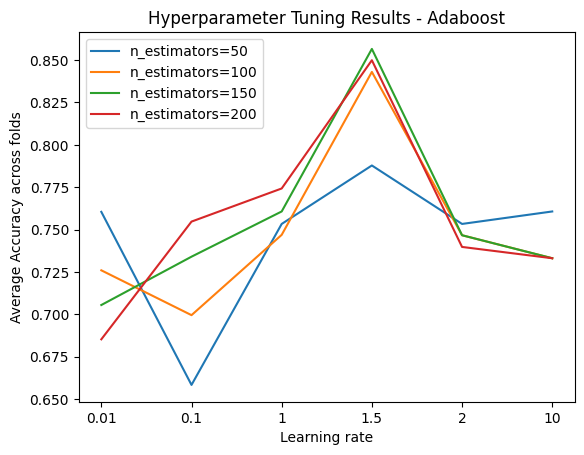

In [15]:
plt.plot(learning_rate,n50_acc,label='n_estimators=50')
plt.plot(learning_rate,n100_acc,label='n_estimators=100')
plt.plot(learning_rate,n150_acc,label='n_estimators=150')
plt.plot(learning_rate,n200_acc,label='n_estimators=200')
plt.xlabel('Learning rate')
plt.ylabel('Average Accuracy across folds')
plt.legend()
plt.title('Hyperparameter Tuning Results - Adaboost')
plt.show()

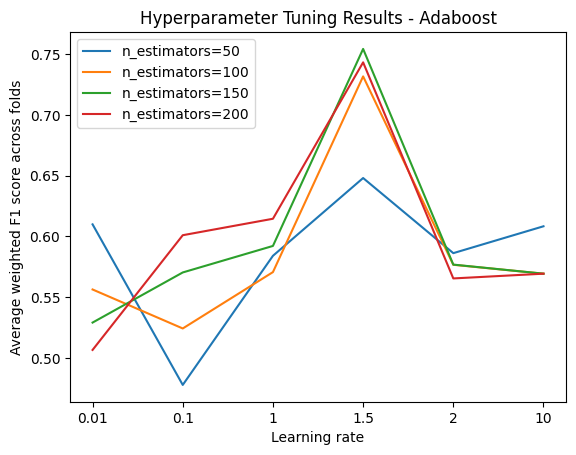

In [16]:
plt.plot(learning_rate,n50_f1,label='n_estimators=50')
plt.plot(learning_rate,n100_f1,label='n_estimators=100')
plt.plot(learning_rate,n150_f1,label='n_estimators=150')
plt.plot(learning_rate,n200_f1,label='n_estimators=200')
plt.xlabel('Learning rate')
plt.ylabel('Average weighted F1 score across folds')
plt.legend()
plt.title('Hyperparameter Tuning Results - Adaboost')
plt.show()

### Testing the Model

In [17]:
## best adaboost model is with 150 estimators and 1.5 learning rate 
best_adaboost_classifier = AdaBoostClassifier(n_estimators=150,learning_rate=1.5,random_state=42)
best_adaboost_classifier.fit(X_train_normalized,y_train)

AdaBoostClassifier(learning_rate=1.5, n_estimators=150, random_state=42)

In [18]:
y_pred = best_adaboost_classifier.predict(X_test_normalized)
ada_metrics = metrics.metrics(y_test,y_pred)
precisions,recalls,f1_scores,macro_f1,weighted_f1 = ada_metrics.f1_score()
acc = ada_metrics.compute_accuracy()

In [19]:
print('\n Accuracy:',acc)
print('\n f1 scores:',f1_scores)
print('\n weighted f1-score:',weighted_f1)
print('\n precisions:',precisions)
print('\n recalls:',recalls)
print('\n macro f1:',macro_f1)


 Accuracy: 0.8648648648648649

 f1 scores: [0.878048780487805, 0, 0.9655172413793104]

 weighted f1-score: 0.7924897142727253

 precisions: [1.0, 0.0, 0.9333333333333333]

 recalls: [0.782608695652174, 0, 1.0]

 macro f1: 0.6145220072890384


## INTERPRETABILITY

[Text(0.5, 0.75, 'A_C2W1T2 <= 0.391\ngini = 0.579\nsamples = 146\nvalue = [0.493, 0.096, 0.411]'),
 Text(0.25, 0.25, 'gini = 0.275\nsamples = 62\nvalue = [0.062, 0.007, 0.356]'),
 Text(0.75, 0.25, 'gini = 0.404\nsamples = 84\nvalue = [0.432, 0.089, 0.055]')]

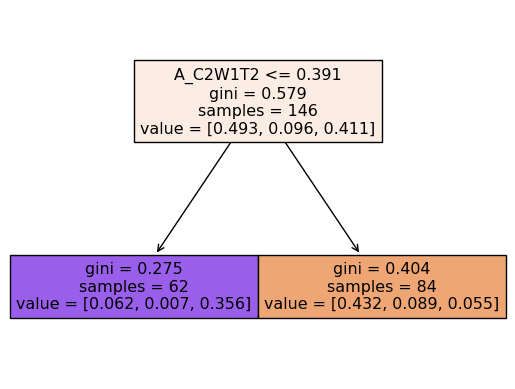

In [20]:
features = X_test_normalized.columns
plot_tree(best_adaboost_classifier.estimators_[0], feature_names=features, filled=True)

[Text(0.5, 0.75, 'A_C2W1T2 <= 0.38\ngini = 0.632\nsamples = 146\nvalue = [0.235, 0.282, 0.483]'),
 Text(0.25, 0.25, 'gini = 0.0\nsamples = 59\nvalue = [0.0, 0.0, 0.483]'),
 Text(0.75, 0.25, 'gini = 0.496\nsamples = 87\nvalue = [0.235, 0.282, 0.0]')]

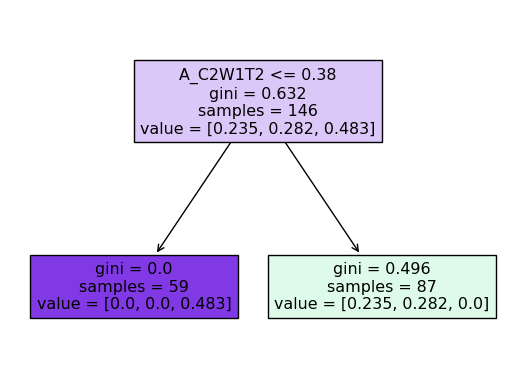

In [27]:
plot_tree(best_adaboost_classifier.estimators_[81], feature_names=features, filled=True)

[Text(0.5, 0.75, 'cC_C2W3T0 <= 0.489\ngini = 0.321\nsamples = 146\nvalue = [0.101, 0.086, 0.813]'),
 Text(0.25, 0.25, 'gini = 0.543\nsamples = 102\nvalue = [0.095, 0.086, 0.009]'),
 Text(0.75, 0.25, 'gini = 0.014\nsamples = 44\nvalue = [0.006, 0.0, 0.804]')]

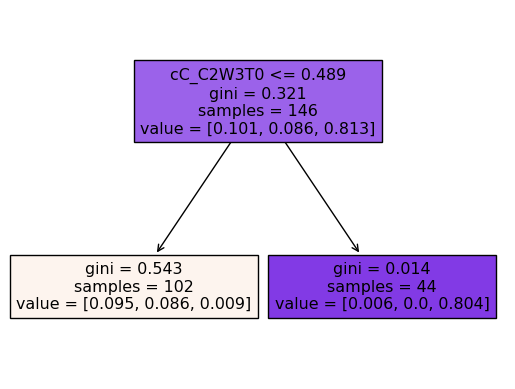

In [29]:
plot_tree(best_adaboost_classifier.estimators_[54], feature_names=features, filled=True)

[Text(0.5, 0.75, 'A_C2W5T2 <= 0.399\ngini = 0.592\nsamples = 146\nvalue = [0.433, 0.456, 0.111]'),
 Text(0.25, 0.25, 'gini = 0.337\nsamples = 105\nvalue = [0.43, 0.004, 0.111]'),
 Text(0.75, 0.25, 'gini = 0.014\nsamples = 41\nvalue = [0.003, 0.451, 0.0]')]

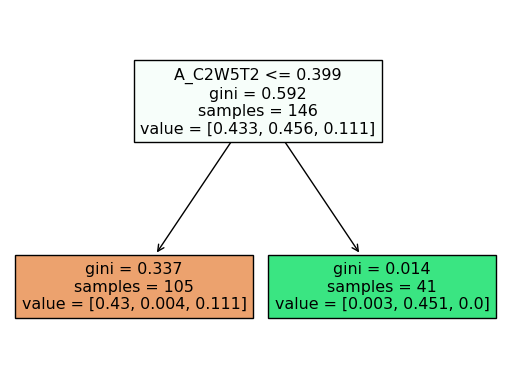

In [22]:
plot_tree(best_adaboost_classifier.estimators_[100], feature_names=features, filled=True)

## VARIABLE IMPORTANCE

In [40]:
## 1. USING THE FEATURE IMPORTANCE SCORE METHOD FROM THE DECISION TREE LIBRARY
features = best_adaboost_classifier.feature_names_in_
feature_importance = best_adaboost_classifier.feature_importances_
feature_imp_indices = np.argsort(feature_importance)[::-1]
features_ranked = features[feature_imp_indices]
features_ranked

Index(['A_C2W1T2', 'A_C1W5T0', 'A_C1W4T0', 'rC_C2W5T2', 'cC_C1W4T2',
       'cC_C2W1T2', 'rC_C2W4T2', 'lC_C2W1T2', 'A_C2W5T2', 'A_C2W2T0',
       ...
       'A_C1W2T2', 'L_C2W1T2', 'Level_70_90', 'rC_C2W5T0', 'lC_C2W4T0',
       'lC_C2W2T0', 'lC_C2W1T0', 'rC_C1W5T0', 'cC_C1W4T0', 'A_C1W1T0'],
      dtype='object', length=103)

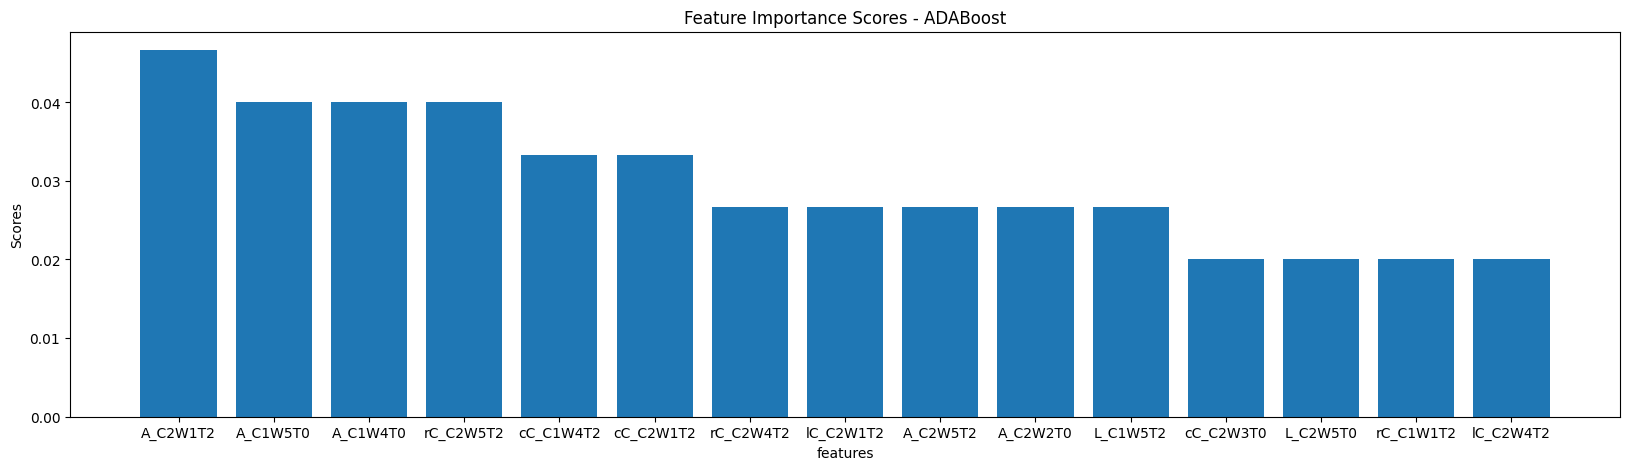

In [50]:
sorted_feature_imp_scores = feature_importance[feature_imp_indices]
plt.figure(figsize=(20,5))
plt.bar(features_ranked[:15],sorted_feature_imp_scores[:15])
plt.xlabel('features')
plt.ylabel('Scores')
plt.title('Feature Importance Scores - ADABoost')
plt.show()

In [43]:
len(features_ranked[non_zero_indices])

65

In [30]:
from sklearn.inspection import permutation_importance

In [31]:
result = permutation_importance(best_adaboost_classifier, X_test_normalized, y_test, n_repeats=10,random_state=42)

In [32]:
result.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [33]:
important_variables_lr = {i:value for i,value in enumerate(result['importances_mean']) if value > 0}
important_var_indices = np.array([key for key,val in important_variables_lr.items()])
importance_scores = np.array([val for key,val in important_variables_lr.items()])

In [34]:
sorted_indices = np.argsort(importance_scores)[::-1]
sorted_scores = importance_scores[sorted_indices]

In [35]:
sorted_scores

array([0.03513514, 0.03243243, 0.02972973, 0.02702703, 0.02432432,
       0.02432432, 0.02162162, 0.02162162, 0.01891892, 0.01621622,
       0.01621622, 0.01351351, 0.01081081, 0.01081081, 0.01081081,
       0.00810811, 0.00810811, 0.00810811, 0.00540541, 0.00540541,
       0.00540541, 0.00540541, 0.0027027 , 0.0027027 ])

In [36]:
sorted_feature_indices = important_var_indices[sorted_indices]
sorted_features = features[sorted_feature_indices]

In [37]:
sorted_features

Index(['A_C1W1T2', 'rC_C1W1T2', 'A_C2W1T2', 'cC_C2W1T2', 'lC_C1W3T0',
       'cC_C1W4T2', 'cC_C1W5T0', 'A_C1W3T0', 'L_C1W5T2', 'cC_C2W3T2',
       'cC_C2W2T0', 'cC_C2W1T0', 'cC_C2W2T2', 'rC_C1W4T0', 'A_C2W4T2',
       'lC_C1W2T2', 'cC_C1W1T2', 'rC_C2W1T2', 'lC_C2W1T2', 'cC_C1W3T2',
       'L_C2W5T2', 'L_C1W4T2', 'rC_C2W5T2', 'rC_C2W3T2'],
      dtype='object')

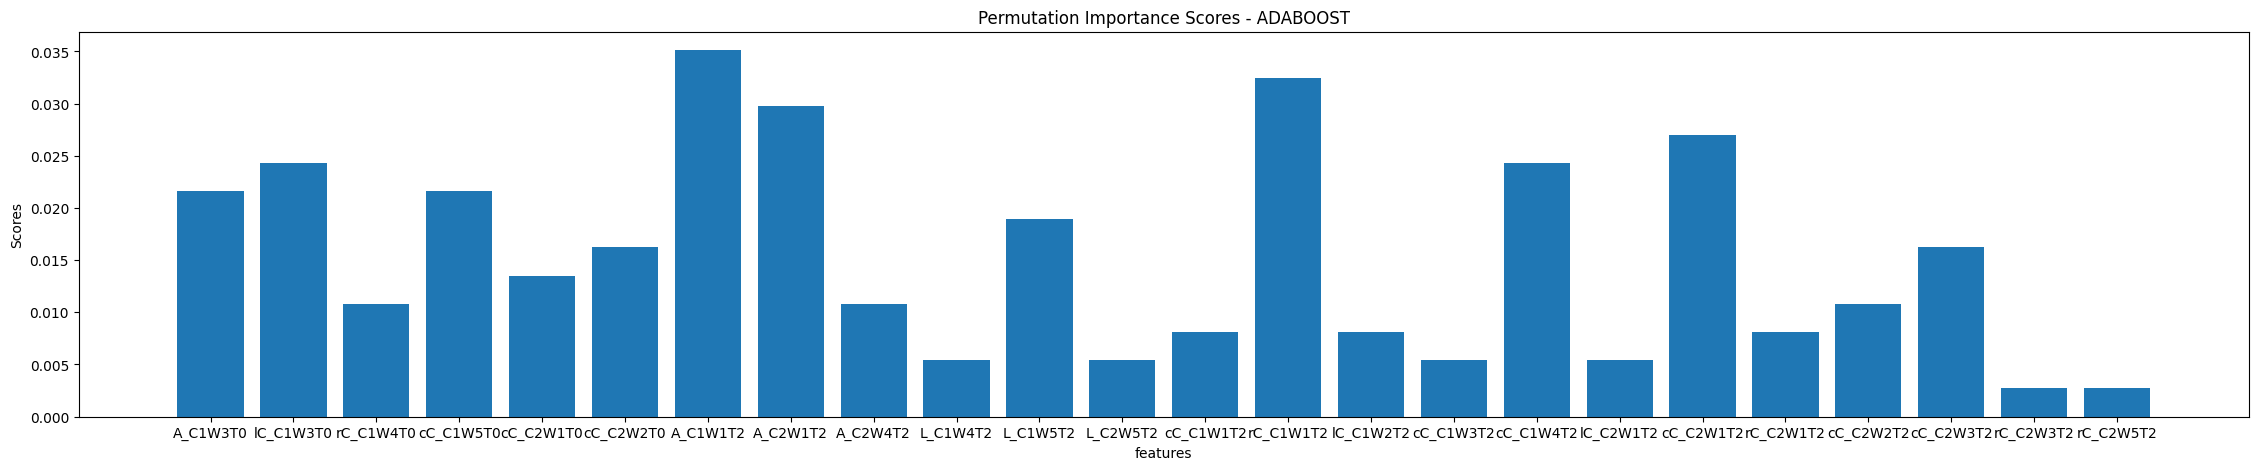

In [48]:
plt.figure(figsize=(28,5))
plt.bar(features[important_var_indices],importance_scores)
plt.xlabel('features')
plt.ylabel('Scores')
plt.title('Permutation Importance Scores - ADABOOST')
plt.show()
